# ML-based torque adjustment in hybrid models for limb movement prediction

Leserri D. (2020). Based on *The use of neural networks in support to existing upper arm models*. Unpublished Bachelor module project, Fachhochschule Bielefeld.

This notebook showcases how a multilayer feedforward neural network (MFNN) can be trained to assist an elbow joint model in predicting arm movements. The elbow joint model used here is based on Hill's classic muscle model [1] and uses electromyography (EMG) signals to predict the angle of an elbow joint. The model has been implemented in MATLAB Simulink. The data used for optimizing the model parameters as well as for training the MFNN is based on experiments in which surface EMG signals of the biceps brachii and triceps brachii -- both muscles which are involved in articulating the elbow --  as well as the correlating joint angle of the elbow where recorded in different subjects.

## Libraries, random seeds and custom functions
<p>
In this section all necessary python libraries are imported, random seeds are set and custom functions are defined.
</p>

In [221]:
# Import of Python libraries
import matplotlib.pyplot as plt, numpy as np, pandas as pd, scipy.io
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras, random as rnd
from IPython.display import display
from warnings import warn

# Set seeds to get reproducable results (not recommended/wanted in general)
np.random.seed(3) 
rnd.set_seed(3)

# Custom functions
# A function to calculate the root mean square (RMS)
def rms(data):
    return np.sqrt(np.mean(np.square(data)))

## Import data

In [158]:
# Load .mat file
filename = 'data/data.mat'
data = scipy.io.loadmat(filename)

# Drop .mat file metadata
for elem in list(data.keys())[:3]:
    del data[elem]
    
# Format data into correct shape
for elem in data:
    data[elem] = data[elem].reshape(len(data[elem][0]),)

# Convert into Pandas dataframe
data = pd.DataFrame.from_dict(data=data)

# Get column names
columns = list(data.columns)

# Get the index of the first triceps curl exercise and slices of each position
first_triceps_curl_index = data['Position'].value_counts()[-1]
biceps_curls = slice(0, first_triceps_curl_index)
triceps_curls = slice(first_triceps_curl_index, -1)

The provided dataset consists of the following data obtained experimentally:

| Key | Unit |
|:---|---|
| Activation_Biceps_Med | n/a |
| Activation_Triceps_Med | n/a |
| Alpha_Simulated | ° |
| Alpha_Target | ° |
| Omega | rad/s |
| Position | n/a |
| Time | s |
| Torque_Biceps | Nm |
| Torque_Difference_Target | Nm |
| Torque_Simulated | Nm |
| Torque_Target | Nm |
| Torque_Triceps | Nm |

### Elbow joint model structure
*Surface electromyography (sEMG)* captures the electric potentials of muscle activation, which are translated to muscle activity via electrochemical pathways. This muscle activity is calculated separately for biceps and triceps through *activation dynamics* [2] as a first step in the model (cf. figure below). Activation signals range from zero (no activity) to one (maximal activity) and are further translated to forces via simulation of *muscle contraction dynamics*. A compliant *tendon model* as well as the *joint geometry* of the elbow determines emerging torques for each, biceps and triceps. In additon a *friction model*, which yields negative torque, is implemented to emulate friction of e.g. muscular tissues. Finally a joint angle is calculated based on *motion equations*. The joint angle and the derived (angular) velocity are fed back recursively within the model.

<img src="fig/hymodel.png" />

## Deviation of predicted and measured joint angles
As shown exemplarily in the figure below, even after optimization of the elbow model parameters, the joint angle over time predicted by the model *without* assistance of an MFNN deviates from the joint angle actually measured in the subject. In this notebook we assume, that activation dynamics as well as the motion equations in the non-hybrid model are determined in a sufficient precise way. Accordingly, the deviation of the predicted and the measured elbow joint angle is based upon differences in torque estimation by the remaining model compartments. 


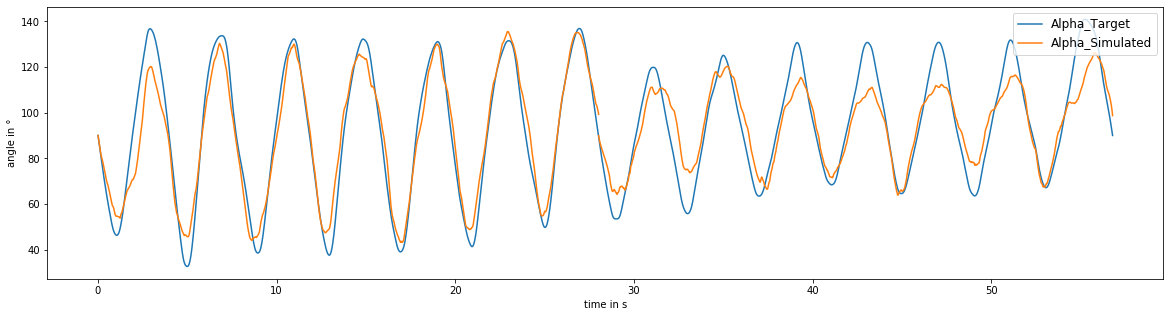

In [159]:
plt.figure(figsize = (20, 5))
plt.xlabel('time in s')
plt.ylabel('angle in °')
plt.plot(data['Time'].to_numpy(), data['Alpha_Target'].to_numpy(), c = 'C0', label = 'Alpha_Target')
plt.plot(data['Time'].to_numpy(), data['Alpha_Simulated'].to_numpy(), c = 'C1', label = 'Alpha_Simulated')
plt.legend(loc = 1, markerscale = 6, fontsize = 'large');

### Torque difference
In order to assist the torque estimation of the non-hybrid model using a MFNN the difference in torque prediction of the elbow joint model and the torque actually employed by the subject to move its arm has to be compared. The torque employed by the subject can be reverse calculated. The difference between those torques is assumed to be the known error.


\begin{equation} 
    Torque_{simulated} = T = Torque_{biceps} + Torque_{triceps}
\end{equation}
     
\begin{equation}
    Torque_{difference} = Torque_{reverse\:calculated} - Torque_{simulated}
\end{equation}

The associated plots of the predicted and reverse calculated torque as well the resulting torque difference to the previously pictured angle are depicted below.

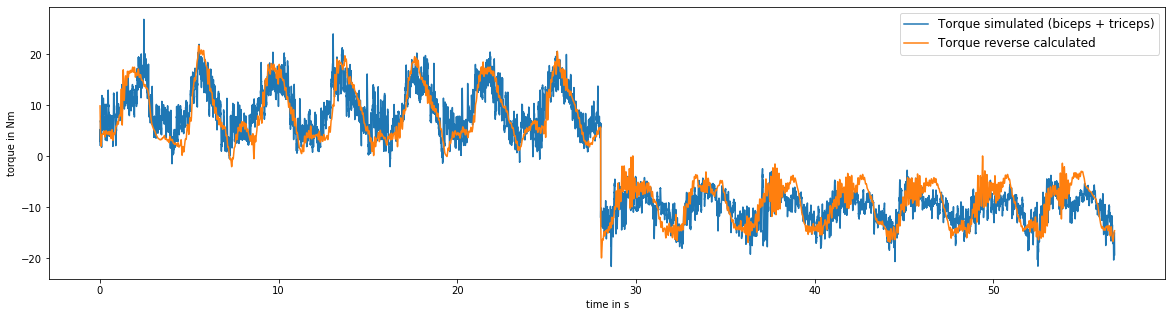

In [160]:
plt.figure(figsize = (20, 5))
plt.xlabel('time in s')
plt.ylabel('torque in Nm')
plt.plot(data['Time'].to_numpy(), data['Torque_Simulated'].to_numpy(), c = 'C0', label = 'Torque simulated (biceps + triceps)')
plt.plot(data['Time'].to_numpy(), data['Torque_Target'].to_numpy(), c = 'C1', label = 'Torque reverse calculated')
plt.legend(loc = 1, markerscale = 6, fontsize = 'large');

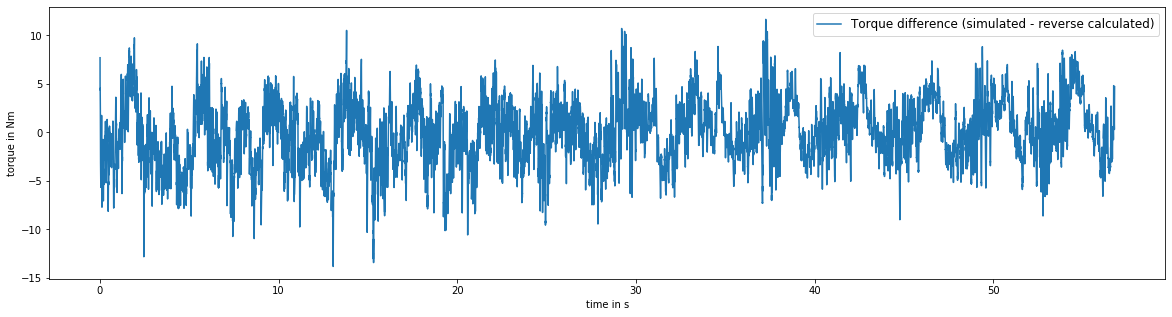

In [161]:
plt.figure(figsize = (20, 5))
plt.xlabel('time in s')
plt.ylabel('torque in Nm')
plt.plot(data['Time'].to_numpy(), data['Torque_Difference_Target'].to_numpy(), c = 'C0', label = 'Torque difference (simulated - reverse calculated)')
plt.legend(loc = 1, markerscale = 6, fontsize = 'large');

In the following the MFNN (*grey box submodel*) is trained to predict torque differences based on activation signals, the joint angle and the (angular) velocity. Thus if the MFNN can be trained efficiently based on torque differences, the resulting hybrid model approach can be used to to predict the joint angle more precisely.

## Moving average

A comparison between the ML-input signal (muscle activation), the ML-output signal (torque difference) and the final hybrid model output (targeted angle) suggests that key information lies in the lower frequency range (cf. plot below). 

Presumably the high frequency characteristics of the activation singnals and torque difference are most likely due to inherited noise from the noisy EMG signal or an internal artifact of the MATLAB Simulink model. Hence it is advisable to apply a low-pass filter to filter superfluous high frequencies.

The moving average operation is a type of convolution with characterics of a low-pass filter and concurrently has the benefit of densing a time window into a single value. Therefore it is well-suited for this type of application, since it is unknown which actual single activation value represents the associated torque difference/angle. A condensed window, depending on its width, represents and includes most likely the actual responsible activation value within a frame of past and/or future activation values.

In this use case moving average is used as a filter with a width of 300 values which represents a time frame of about 333 ms to filter the high frequency characteristics of the activation signals, torque signals and angular velocity.

In [162]:
window_width = 300

ma_data = pd.DataFrame()

for key in data.keys():
    if 'Activation' in key or'Torque' in key and not 'Difference' in key or 'Omega' in key:
        ma_data[key] = data[key].rolling(window_width).mean()
    else:
        ma_data[key] = data[key]       

ma_data['Torque_Difference_Target'] = ma_data['Torque_Target'] - ma_data['Torque_Simulated']

ma_data = ma_data.dropna()

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


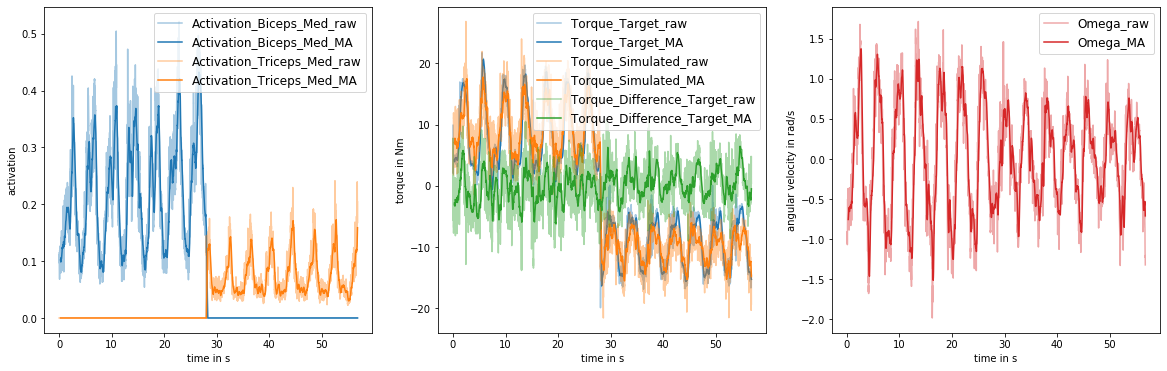

In [163]:
plot_label = [['Activation_Biceps_Med', 'Activation_Triceps_Med'], ['Torque_Target', 'Torque_Simulated', 'Torque_Difference_Target'], ['Omega']]

y_label = ['activation', 'torque in Nm', 'angular velocity in rad/s']

fig, ax = plt.subplots(1, 3,figsize=(20, 6))
for i in range(3):
    for j, key in enumerate(plot_label[i]):
        ax[i].plot(data['Time'].to_numpy(), data[key].to_numpy(), label = key + '_raw' , color = 'C' + str(j) if i < 2 else 'C3', alpha = 0.4)
        ax[i].plot(ma_data['Time'].to_numpy(), ma_data[key].to_numpy(), label = key + '_MA' , color = 'C' + str(j) if i < 2 else 'C3')
    ax[i].set_xlabel('time in s')
    ax[i].set_ylabel(y_label[i])
    ax[i].legend(markerscale = 6, fontsize = 'large');

## Define input(s) and output(s) of grey box submodel

For this specific exemplary hybrid model the inputs and outputs are defined as follows:

**Inputs:**
- Activation Biceps Medial
- Activation Triceps Medial
- Target Angle
- Angular velocity Omega
- Position

**Output:**
- Torque Difference

In [164]:
# Specify input and output labels
input_label = ['Activation_Biceps_Med', 'Activation_Triceps_Med', 'Alpha_Target', 'Omega', 'Position']
output_label = ['Torque_Difference_Target']

## Normalizing inputs and outputs

For this exemplary ML model the `tanh` (Hyperbolic Tangent) function is used as the activation function in all layers of the grey box submodel. To achieve a higher convergence of the ML model and operate within the workspace of the `tanh`, inputs are normalized to a range of -1 to 1.

In [165]:
# Initialize dictionary holding scalers
scaler = {}

for key in np.r_[input_label, output_label]:
    # Generating new scaler
    scaler[key] = MinMaxScaler(feature_range=(-1, 1))
    # Scale data
    ma_data[key] = scaler[key].fit_transform(ma_data[key].to_numpy().reshape(len(ma_data[key]), 1))

## Input data
A first visual look at the input data is helpful to determine if the chosen dataset is appropriate to represent the given problem and to check if the scaling has been applied correctly. For the experiments subjects were asked to modulate the movement of the lower arm sinusoidally while recording the elbow joint angle and biceps and triceps muscle activation via sEMG. Hence, a periodic modulation of the elbow joint angle ($\alpha$) and the angular velocity ($\omega$) can be observed in the figure depicted below.

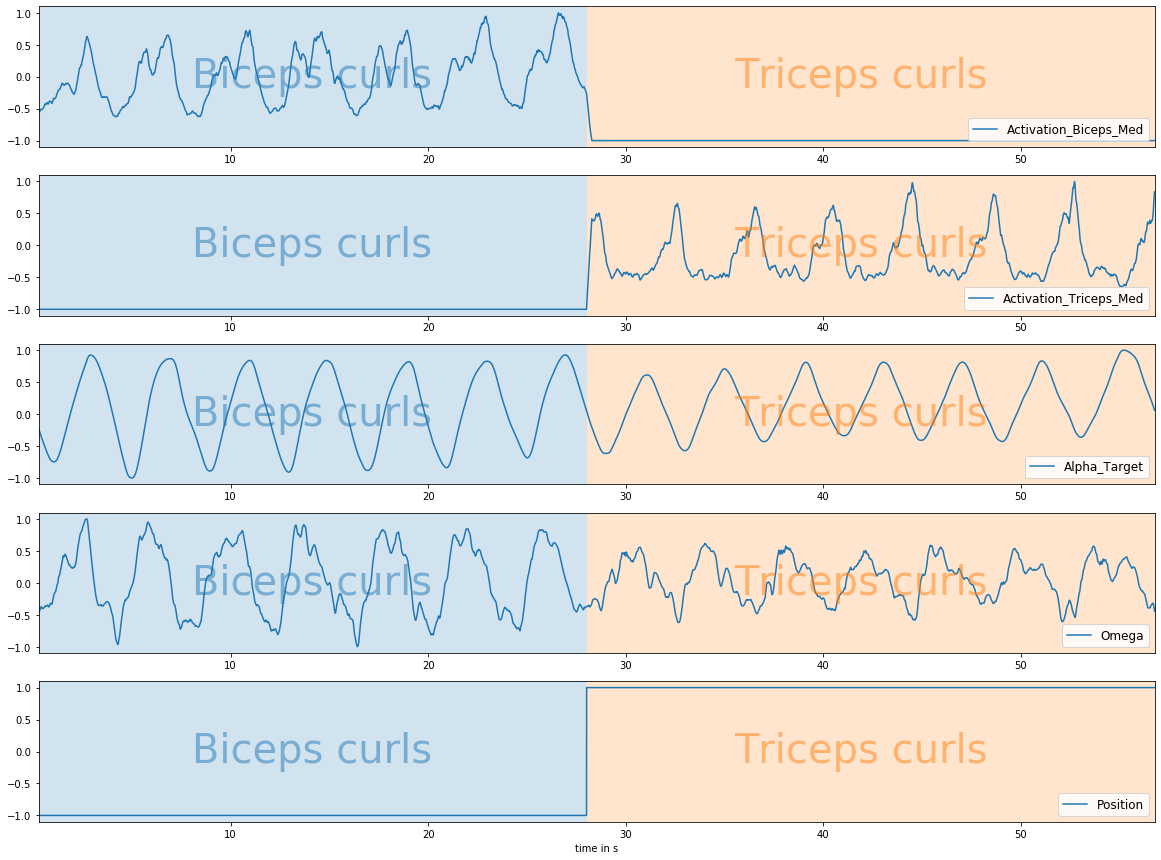

In [182]:
fig, ax = plt.subplots(len(input_label), 1, figsize = (20, len(input_label) * 3))

first_triceps_curl_index = ma_data['Position'].value_counts()[-1]
biceps_curls = slice(0, first_triceps_curl_index)
triceps_curls = slice(first_triceps_curl_index, -1)

x_start = ma_data['Time'][ma_data['Time'].index[0]]
x_quad_1 = ma_data['Time'][ma_data['Time'].index[int(first_triceps_curl_index * 0.5)]]
x_mid = ma_data['Time'][ma_data['Time'].index[first_triceps_curl_index]]
x_quad_3 = ma_data['Time'][ma_data['Time'].index[int(first_triceps_curl_index * 1.5)]]
x_end = ma_data['Time'][ma_data['Time'].index[-1]]

for i, key in enumerate(input_label):
    ax[i].set_xlim(x_start, x_end)
    ax[i].axvspan(x_start, x_mid, facecolor = 'C0', alpha = 0.2)
    ax[i].axvspan(x_mid, x_end, facecolor = 'C1', alpha = 0.2)
    ax[i].text(x_quad_1, 0, 'Biceps curls', horizontalalignment='center', verticalalignment='center', fontsize = 40, color='C0', alpha=.5)
    ax[i].text(x_quad_3, 0, 'Triceps curls', horizontalalignment='center', verticalalignment='center', fontsize = 40, color='C1', alpha=.5)
    ax[i].plot(ma_data['Time'].to_numpy(), ma_data[key].to_numpy(), label = key, c = 'C0')
    ax[i].legend(loc = 4, markerscale = 6, fontsize = 'large')
plt.xlabel('time in s');

However, when comparing the corresponding sEMG data recorded for biceps and triceps over time, a separation of the muscle activity pattern is apparent. In the first part (0 - 28 s) the biceps is active and the triceps inactive, whereas in the second part (28 - 56 s) the activation pattern is reversed. This reversal in activity is due to two different arm poses while the subject performed lower arm movements in the experiments. The predominant activation of the biceps can be explained by the subject performing so-called biceps curls, requiring the biceps, but not the triceps to be active. In contrast, the main activation of the triceps in the second part is due to the subject performing triceps curls, requiring mainly the triceps but not the biceps to be active.

## Output data
When plotting the difference between the torque reverse calculated from the experimental data and the torque predicted by the elbow joint model, a certain amount of high frequency modulations is observable. This noise component stems from within the model, but will be ignored for the sake of simplicity.

A visual comparison of both parts in the dataset shows almost no distinction between the experiments.

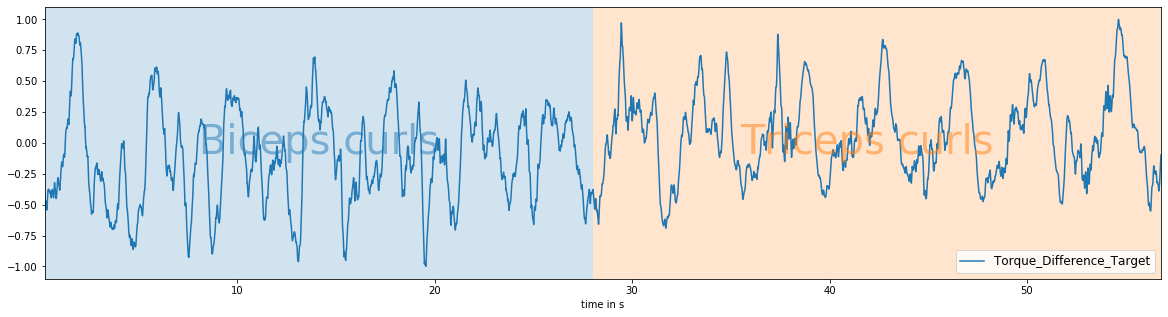

In [167]:
plt.figure(figsize = (20, 5))
plt.xlim(x_start, x_end)
plt.axvspan(x_start, x_mid, facecolor = 'C0', alpha = 0.2)
plt.axvspan(x_mid, x_end, facecolor = 'C1', alpha = 0.2)
plt.text(x_quad_1, 0, 'Biceps curls', horizontalalignment='center', verticalalignment='center', fontsize = 40, color='C0', alpha=.5)
plt.text(x_quad_3, 0, 'Triceps curls', horizontalalignment='center', verticalalignment='center', fontsize = 40, color='C1', alpha=.5)
plt.plot(ma_data['Time'].to_numpy(), ma_data['Torque_Difference_Target'].to_numpy(), label = 'Torque_Difference_Target', c = 'C0')
plt.legend(loc = 4, markerscale = 6, fontsize = 'large')
plt.xlabel('time in s');

## Prepare train and test datasets
Before training the actual grey box submodel the dataset must be divided into a train and a test dataset (cf. below). The train to test dataset ratio is defined as 70% (train data) to 30% (test data). Note that data is shuffled.

In [168]:
data_lower_pos = ma_data[ma_data['Position'] == -1]
data_upper_pos = ma_data[ma_data['Position'] == 1]

# train to test dataset ratio
train_size = .7

x_train_lower, x_test_lower, y_train_lower, y_test_lower = train_test_split(data_lower_pos[input_label], data_lower_pos[output_label], train_size = train_size, shuffle = False)
x_train_upper, x_test_upper, y_train_upper, y_test_upper = train_test_split(data_upper_pos[input_label], data_upper_pos[output_label], train_size = train_size, shuffle = False)

In [169]:
x_train = x_train_lower.append(x_train_upper)
y_train = y_train_lower.append(y_train_upper)
x_test  = x_test_lower.append(x_test_upper)
y_test  = y_test_lower.append(y_test_upper)

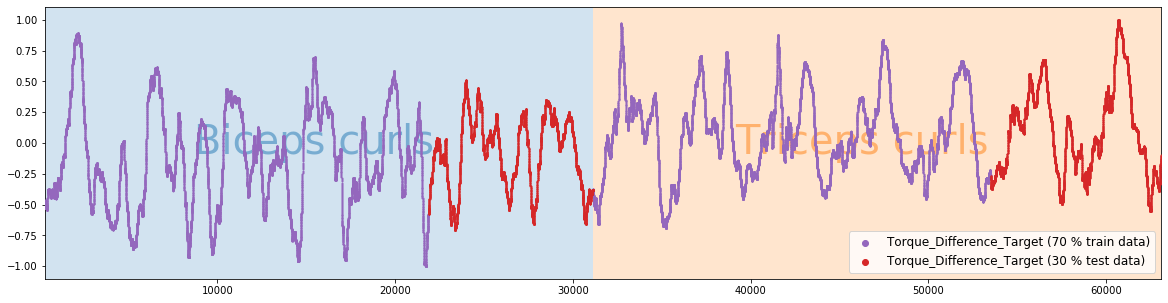

In [170]:
x_start = ma_data.index[0]
x_mid = first_triceps_curl_index + window_width
x_quad_1 = int(first_triceps_curl_index * 0.5)
x_quad_3 = int(first_triceps_curl_index * 1.5)
x_end = ma_data.index[-1]

plt.figure(figsize = (20, 5))
plt.xlim(x_start, x_end)
plt.axvspan(x_start, x_mid, facecolor = 'C0', alpha = 0.2)
plt.axvspan(x_mid, x_end, facecolor = 'C1', alpha = 0.2)
plt.text(x_quad_1, 0, 'Biceps curls', horizontalalignment='center', verticalalignment='center', fontsize = 40, color='C0', alpha=.5)
plt.text(x_quad_3, 0, 'Triceps curls', horizontalalignment='center', verticalalignment='center', fontsize = 40, color='C1', alpha=.5)

plt.scatter(y_train.index, y_train, c = 'C4', s = 1, label = 'Torque_Difference_Target (70 % train data)', zorder = 10)
plt.scatter(y_test.index, y_test, c = 'C3', s = 1, label = 'Torque_Difference_Target (30 % test data)', zorder = 10)
plt.legend(loc=4, markerscale = 6, fontsize = 'large');

## Model training
<p>

</p>

The neural network structure used as a greybox model is a simple multilayer feedforward network consisting of two hidden layers with four hidden layer neurons each. As stated above, the activation function used in all layers is the Hyperbolic Tangent function (`tanh`).

<img src="fig/networkstructure.png" />

In [171]:
model = keras.Sequential([
    keras.layers.Dense(4, input_shape=(len(input_label),),  activation='tanh'),
    keras.layers.Dense(4,  activation='tanh'),
    keras.layers.Dense(len(output_label), activation='tanh')
])

In [172]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-3), loss='mean_squared_error')
history = model.fit(np.asarray(x_train), np.asarray(y_train), batch_size=512, epochs=40, validation_split=0.1, shuffle=True)

Epoch 1/40
78/78 [==============================] - 0s 2ms/step - loss: 0.1892 - val_loss: 0.1049
Epoch 2/40
78/78 [==============================] - 0s 834us/step - loss: 0.1243 - val_loss: 0.1031
Epoch 3/40
78/78 [==============================] - 0s 833us/step - loss: 0.1069 - val_loss: 0.1009
Epoch 4/40
78/78 [==============================] - 0s 803us/step - loss: 0.0967 - val_loss: 0.0942
Epoch 5/40
78/78 [==============================] - 0s 811us/step - loss: 0.0901 - val_loss: 0.0931
Epoch 6/40
78/78 [==============================] - 0s 814us/step - loss: 0.0848 - val_loss: 0.0881
Epoch 7/40
78/78 [==============================] - 0s 807us/step - loss: 0.0836 - val_loss: 0.0846
Epoch 8/40
78/78 [==============================] - 0s 826us/step - loss: 0.0799 - val_loss: 0.0797
Epoch 9/40
78/78 [==============================] - 0s 838us/step - loss: 0.0810 - val_loss: 0.0807
Epoch 10/40
78/78 [==============================] - 0s 857us/step - loss: 0.0776 - val_loss: 0.0783
E

In [173]:
print("Evaluate on test data")
results = model.evaluate(np.asarray(x_test), np.asarray(y_test), batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
148/148 [==============================] - 0s 327us/step - loss: 0.0691
test loss, test acc: 0.06910201907157898


## Analysis
### Model training history
The first step is to delimit whether the model might be under- or overfitted. To achieve that, losses of train and validation data in each epoch have been calculated and tracked. If both tend to converge mutually it is a strong hint, that neither under- nor overfitting has taken place, which is the case (cf. below).

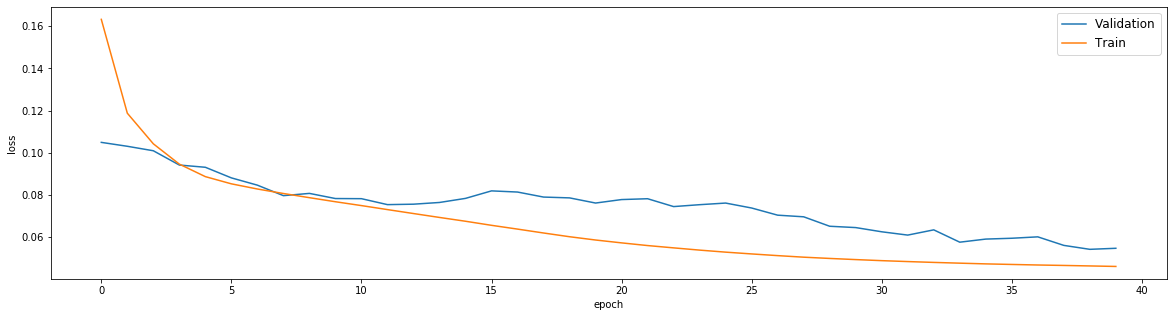

In [174]:
fig = plt.figure(figsize=(20,5))
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.legend(['Validation','Train'], markerscale = 6, fontsize = 'large')
plt.ylabel('loss')
plt.xlabel('epoch');

### Prediction of torque differences
<p>
After a successful training, the model can predict torque differences solely based on inputted data.
</p>

In [175]:
# Prediction
ma_data['Torque_Difference_Predicted'] = model.predict(ma_data[input_label])

### Denormalization
<p>
For a correct application in a hybrid model, torque differences must be denormalized after prediction.
</p>

In [176]:
# Denormalize torque differences
ma_data['Torque_Difference_Target'] = scaler['Torque_Difference_Target'].inverse_transform(ma_data['Torque_Difference_Target'].to_numpy().reshape(len(ma_data['Torque_Difference_Target']), 1))
ma_data['Torque_Difference_Predicted'] = scaler['Torque_Difference_Target'].inverse_transform(ma_data['Torque_Difference_Predicted'].to_numpy().reshape(len(ma_data['Torque_Difference_Target']), 1))
ma_data['Torque_Difference_Corrected'] = ma_data['Torque_Difference_Target'] - ma_data['Torque_Difference_Predicted']

### Contrast of predicted and original torque differences
The predicted torque differences are compared with the original torque differences (cf. below). Visually the orange curve approximates the course of the curve of the original torque difference quite well. To quantify and evaluate the precision of the predictions, the root mean square (RMS) of the original torque differences is compared to the RMS of the predicted torque subtracted from the original torque differences.

In [218]:
dftrain  = ma_data.loc[x_train.index]
dftest = ma_data.loc[x_test.index] 

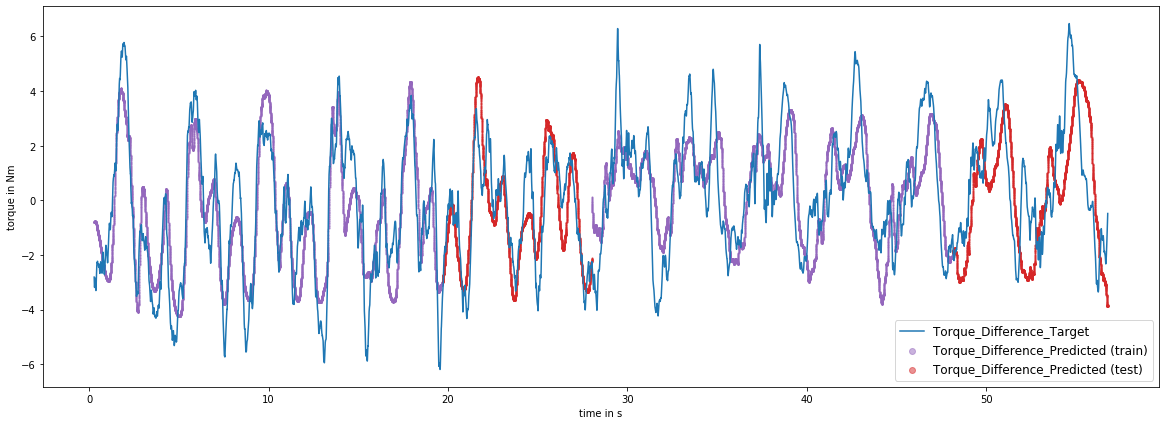

In [219]:
plt.figure(figsize = (20, 7))
plt.plot(ma_data['Time'].to_numpy(), ma_data['Torque_Difference_Target'].to_numpy(), c = 'C0', label = 'Torque_Difference_Target')
plt.scatter(dftrain['Time'].to_numpy(), dftrain['Torque_Difference_Predicted'].to_numpy(), c = 'C4', s = 1, alpha = 0.5, label = 'Torque_Difference_Predicted (train)');
plt.scatter(dftest['Time'].to_numpy(), dftest['Torque_Difference_Predicted'].to_numpy(), c = 'C3', s = 1, alpha = 0.5, label = 'Torque_Difference_Predicted (test)');
plt.xlabel('time in s')
plt.ylabel('torque in Nm')
plt.legend(loc = 4, markerscale = 6, fontsize = 'large');

Since the original torque differences represent the error of the predicted torques within the non-hybrid elbow joint model, the resulting RMS is a reference value of how precise said model predicts torques. If the RMS is zero, torques are predicted perfectly making a hybrid model approach obsolete. Thus, the nearer the RMS is to zero the more precise the model operates.

In [220]:
print(f"without MFNN: RMS= {rms(ma_data['Torque_Difference_Target']):.2f}")
print(f"with MFNN:    RMS= {rms(ma_data['Torque_Difference_Corrected']):.2f}")

without MFNN: RMS= 2.37
with MFNN:    RMS= 1.46


# References

[1] A. V. Hill, "The heat of shortening and the dynamic constants of muscle", *Proceedings of the Royal Society of London. Series B, Biological Sciences*, vol. 126, issue 843, pp. 136-195, 1938

[2] F. E. Zajac, “Muscle and tendon: properties, models, scaling, and application to biomechanics and motor control”, *Critical reviews in biomedical engineering*, vol. 17, no. 4, pp. 359–411, 1989